In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = "../../../workspace"

In [3]:
import torch
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM, PreTrainedModel, PreTrainedTokenizer, GenerationConfig

/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [10]:
from steering_vectors.train_steering_vector import extract_steering_vector

In [4]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

model.safetensors.index.json: 100%|██████████| 26.8k/26.8k [00:00<00:00, 21.3MB/s]
model-00001-of-00002.safetensors: 100%|██████████| 9.98G/9.98G [00:39<00:00, 255MB/s]
model-00002-of-00002.safetensors: 100%|██████████| 3.50G/3.50G [00:14<00:00, 240MB/s]
tokenizer_config.json: 100%|██████████| 776/776 [00:00<00:00, 1.28MB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 11.3MB/s]
special_tokens_map.json: 100%|██████████| 414/414 [00:00<00:00, 917kB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 3.56MB/s]


In [6]:
def get_completion(
    model,
    tokenizer,
    text,
    max_new_tokens=30,
):
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

In [7]:
completion = get_completion(
    model,
    tokenizer,
    "Canada -> Ottawa, China -> Beijing, France -> Paris, India ->",
    max_new_tokens=5,
)

/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [11]:
icl_prompt = "Canada -> Ottawa, China -> Beijing, France -> Paris," 

In [12]:
capital_data = [
    ("Germany", "Berlin"),
    ("United Kingdom", "London"),
    ("Austria", "Vienna"),
    ("Italy", "Rome"),
    ("Japan", "Tokyo"),
    ("Egypt", "Cairo"),
    ("USA", "Washington"),
    ("Brazil", "Brasilia"),
    ("Russia", "Moscow"),
    ("Australia", "Canberra"),
    ("Netherlands", "Amsterdam"),
    ("Belgium", "Brussels"),
    ("Ireland", "Dublin"),
    ("Mexico", "Mexico City"),
    ("Spain", "Madrid"),
    ("Portugal", "Lisbon"),
    ("Sweden", "Stockholm"),
    ("Vietnam", "Hanoi"),
    ("Philippines", "Manila"),
    ("South Africa", "Pretoria"),
]

In [78]:
def get_nth_token(word, tokenizer, n):
    return tokenizer.convert_ids_to_tokens(tokenizer.encode(word))[n]

In [82]:
acc_with_icl_prompt = 0
acc_baseline = 0
for country, capital in capital_data:
    full_icl_prompt = icl_prompt + f", {country} ->"
    target_token = get_nth_token(capital, tokenizer, 1)
    icl_completion = get_completion(
        model,
        tokenizer,
        full_icl_prompt,
        max_new_tokens=1,
    )[0]
    output_token = get_nth_token(icl_completion, tokenizer, -1)
    if target_token.lower() == output_token.lower():
        acc_with_icl_prompt += 1
    task_prompt = f"{country} ->"
    basline_completion = get_completion(
        model,
        tokenizer,
        task_prompt,
        max_new_tokens=1,
    )[0]
    output_token = get_nth_token(basline_completion, tokenizer, -1)
    if target_token.lower() == output_token.lower():
        acc_baseline += 1

acc_with_icl_prompt /= len(capital_data)
acc_baseline /= len(capital_data)

In [85]:
task_vector_accs = []
# add dummy task to extract task vector
prompt = icl_prompt + " Switzerland ->"
completions = []

for layer in range(32):
    task_vector = extract_steering_vector(
        model,
        tokenizer,
        prompt,
        layers=[layer],
    )
    layer_accuracy = 0
    layer_completions = []
    for country, capital in capital_data:
        target_token = get_nth_token(capital, tokenizer, 1)
        task_prompt = f"{country} ->"
        with task_vector.apply(model, min_token_index=1):
            task_vector_completion = get_completion(
                model,
                tokenizer,
                task_prompt,
                max_new_tokens=1,
            )[0]
            layer_completions.append(task_vector_completion)
            output_token = get_nth_token(task_vector_completion, tokenizer, -1)
        if target_token.lower() in output_token.lower():
            layer_accuracy += 1
    completions.append(layer_completions)
    task_vector_accs.append(layer_accuracy / len(capital_data))

/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/steering-vectors-pCHwRNkN-py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


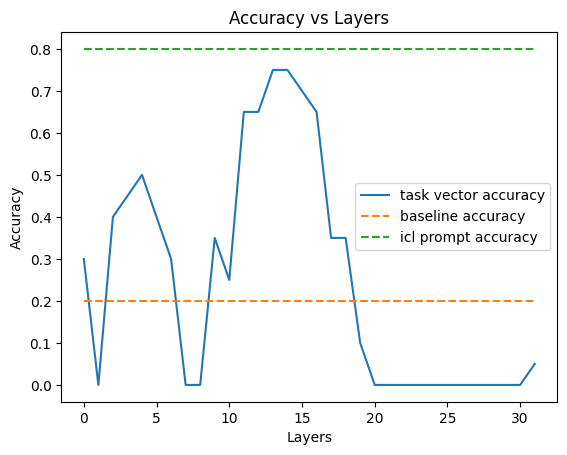

In [90]:
import matplotlib.pyplot as plt

plt.plot(list(range(32)), task_vector_accs, label="task vector accuracy")
plt.plot(list(range(32)), [acc_baseline] * 32, label="baseline accuracy", linestyle="--")
plt.plot(list(range(32)), [acc_with_icl_prompt] * 32, label="icl prompt accuracy", linestyle="--")
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Layers')
plt.legend()
plt.show()